In [1]:
print "hi", 2+2


hi 4


In [3]:
%run setup.py              # computations used to generate the tables and graphs
dsp.HTML(data=styleHTML)   # applies some styling

# Performance Testing - Preliminary Results

## Background

We are in the process of performing functional, performance, and stress testing on the sensor network in its current state. This testing work is being [tracked on basecamp](https://basecamp.com/2077813/projects/2597297-pp-sensor/messages/20065815), and this report shows some of the initial performance test results.

The results here are preliminary, and do not take all factors into account. Once the entire test plan above is complete we'll have a much clearer picture. However, the information here should still help us understand roughly the kinds of speeds the system is capable of.

## Testing Setup

The main components are:

 * ___Router___ <small>(_380-10196_)</small><br>
 A basic ethernet router that assigns IP addresses and routes packets.
 * ___Sensor Boards___ <small>(board: _[250-10095](https://bitbucket.org/pedalpower/250-10095-pcb-assy-bike-sensor-board-gen-2)_; firmware: _[400-10168](https://bitbucket.org/pedalpower/400-10168-firmware-bike-sensor-board)_)</small><br>
 Custom sensor boards and firmware. We are currently experimenting with the [EtherCard library](https://github.com/jcw/ethercard) and [ENC28J60](www.microchip.com/ENC28J60) chip for communication. The boards connect to the router to get an IP address and then transmit a message containing sensor data at a regular, configurable interval (e.g. once every 10 ms).
 * ___Network Switch___ <small>(_380-10206_)</small><br>
 Allows us to plug in more nodes.
 * ___Venue Server___ <small>(Pi: _381-10198_; software: _[401-10191](https://bitbucket.org/pedalpower/venue-server)_)</small><br>
 A Raspberry Pi running a node.js application that gets data from the sensor boards, optionally logs the raw data to disk, computes some metrics about the data as it comes in, provides a web-based UI for viewing the network state).

The sensor nodes currently send their data as individual, JSON-formatted UDP packets to the venue server, which provides us with a very easy to parse (if somewhat heavy) data format over a fast but sometimes unreliable protocol.

The terms "node", "sensor node", and "sensor board" are used interchangeably. Each piece of gear we want to monitor (bikes, amplifiers, the charge controller, etc) will correspond to one sensor node.

The images below show how everything is physically connected:

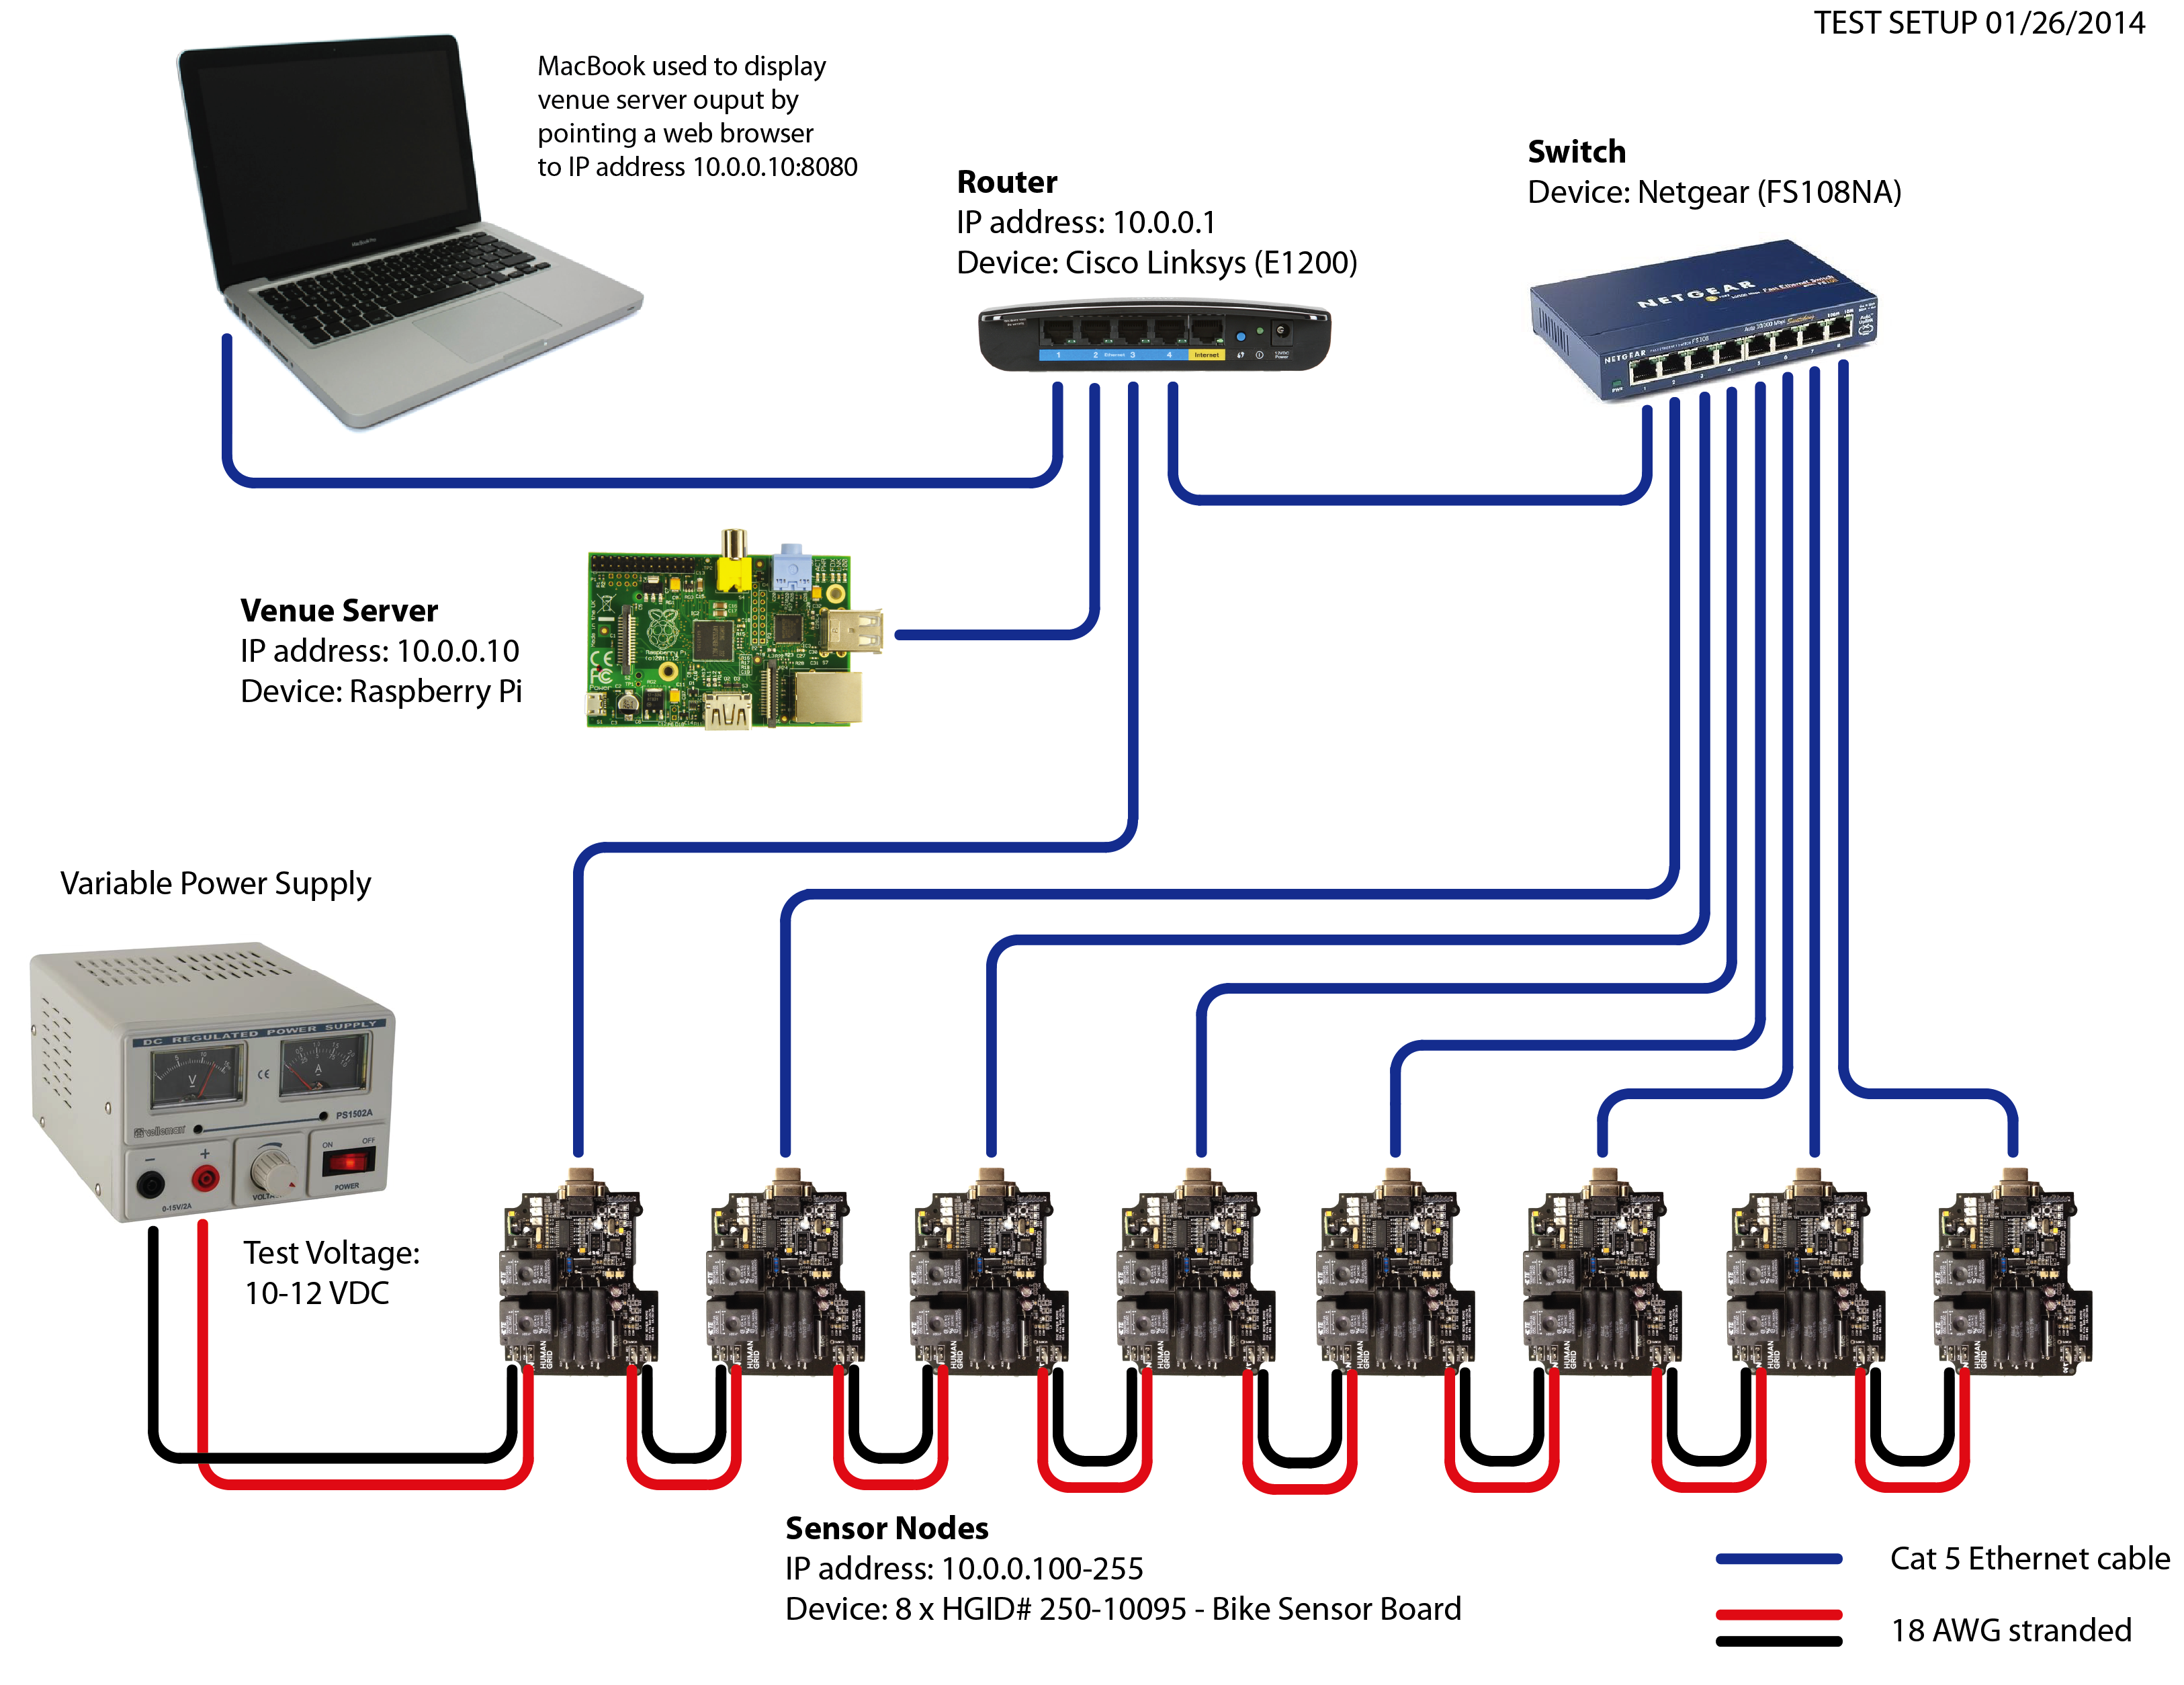

In [4]:
dsp.Image(filename='systemDiagram.png', format='png')

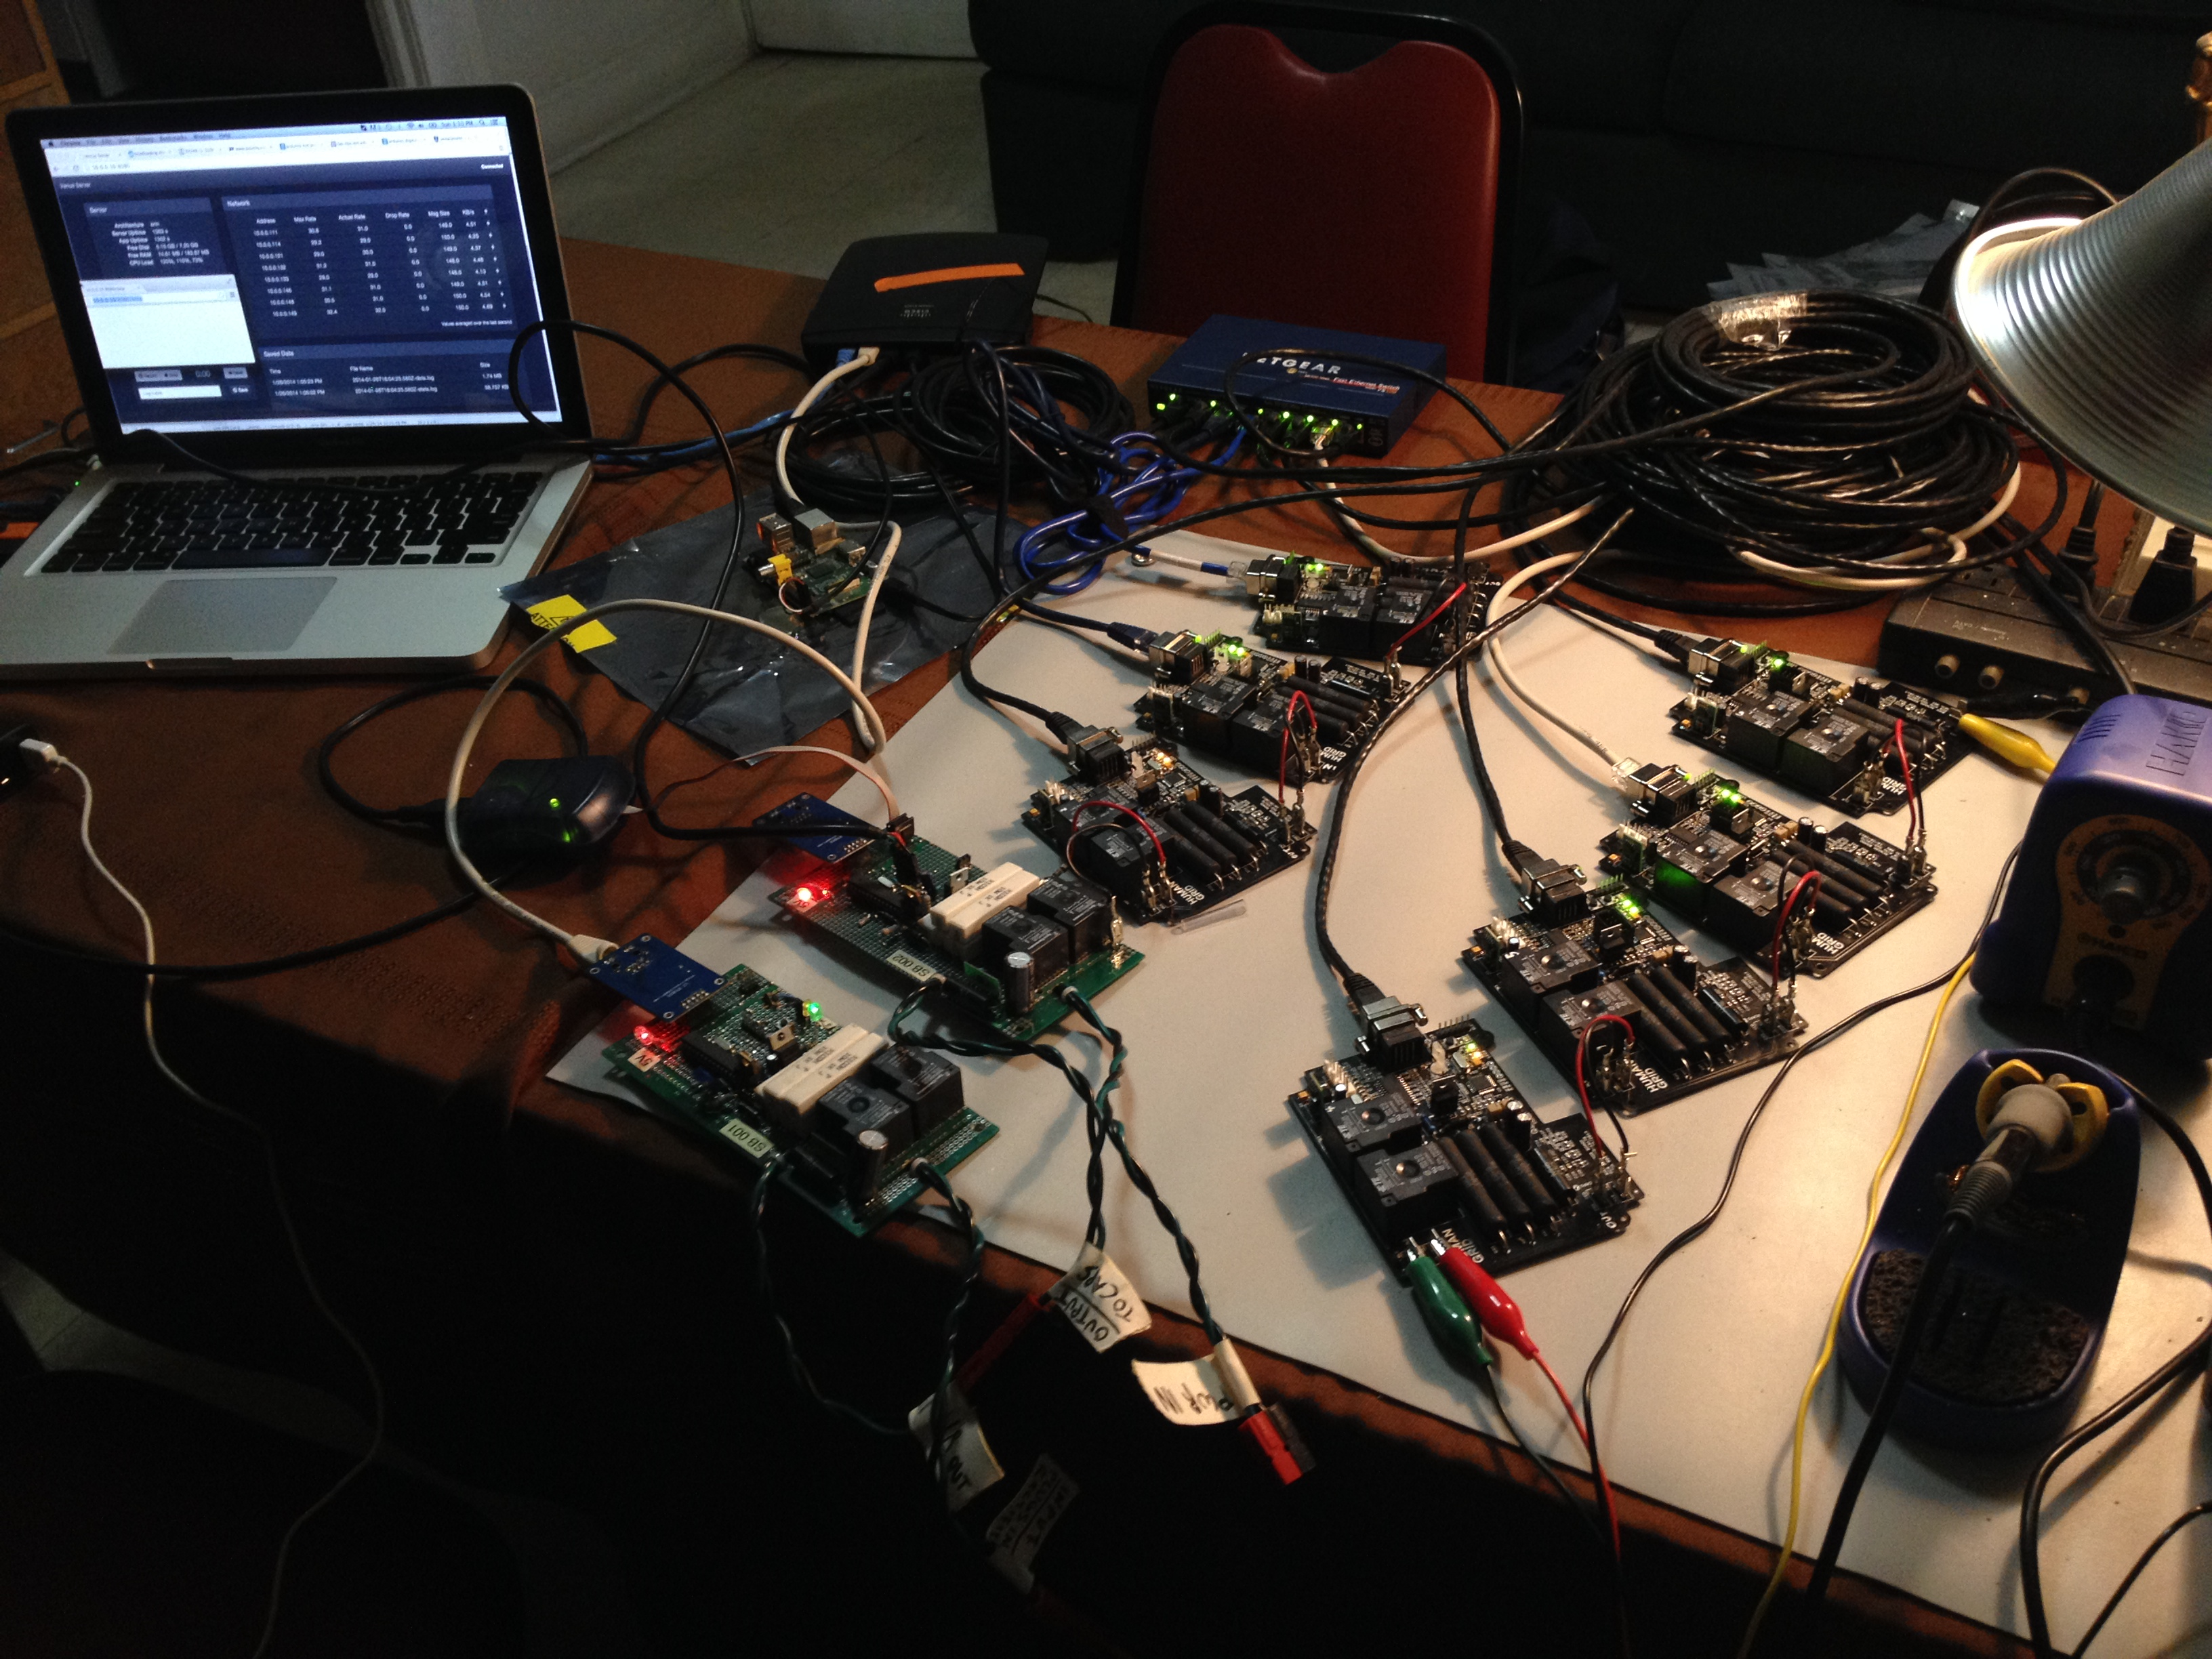

In [5]:
dsp.Image(filename='systemPhoto.jpg')

## Problems with Logging

The Venue Server is capable of both logging all incoming sensor data to disk and also displaying a live view of some aggregated metrics in a web page.

Initial testing showed that logging to disk (in our case an SD card on the Raspberry Pi) was a bottleneck and was preventing us from obtaining accurate measurements. Whenever we were logging data, CPU load would get very high, messages would start to drop, and the maximum data rates would go way down.

We wanted to get some initial results that would give us a sense of the raw achievable network speeds independent of these issues, so we used a hack solution: a sequence of screenshots of the Venue Server live view was taken with logging turned off. They all look something like this:

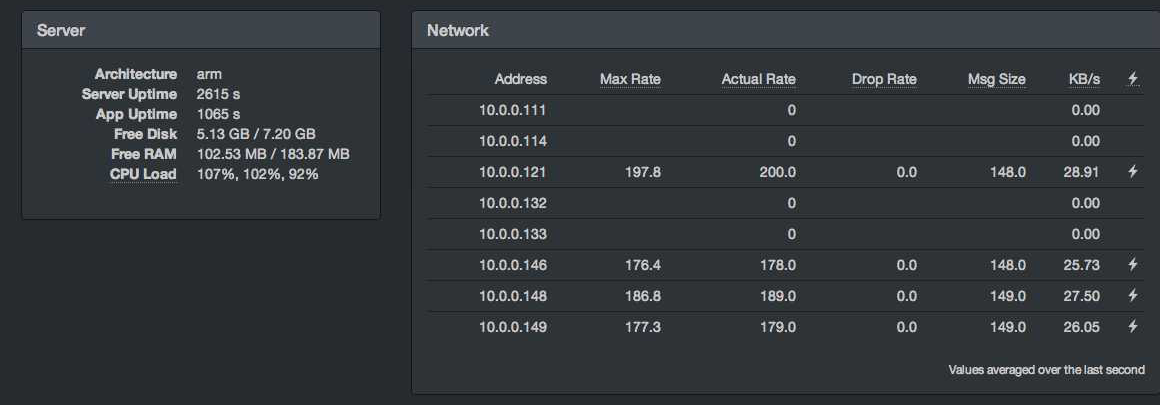

In [6]:
dsp.Image(filename='no-logging/4a.png')

Notes:

 * ___Max Rate___ a.k.a. ___Throttle Rate___ (messages per second) is determined by the amount of time that the sensor waits between sending messages. If sending a message takes too long, the next message is simply sent when the previous one is finished (they do not overlap). In theory, the actual rate (as measured by the server) should always be less than the throttle rate (as reported by the sensor).
 * ___Actual Rate___ (messages per second) is calculated by the venue server as the number of messages received in the last second.
 * ___Drop Rate___ (messages per second) is calculated by the venue server by watching for missing IDs: each sensor attaches an incrementing number to each message it sends.
 * ___Msg Size___ (bytes) is the average size of the over-the-wire messages received over the last second.
 * ___KB/s___ is calculated as $ \frac{\text{Actual Rate} \cdot \text{Msg Size}}{1024} $


## Testing Process

Starting with 8 sensor nodes, we performed the following steps:

 * increase the ___Throttle Rate___ on all sensors roughly equally until we just begin to see some dropped nodes
 * take screenshot of venue server UI (a __stressed__ state, where data is beginning to be lost)
 * remove one node from the network
 * take screenshot of venue server UI (a __safe__ or __unstressed__ state, where no data is lost)
 * repeat

So to be clear, we define the network as:

 * __safe__ when the network is close to maximum throughput but not dropping data
 * __stressed__ when all the sensors were running fast enough that messages were just beginning to be lost

Our data covers the cases of 4-8 nodes because:

 * Below 4 nodes, we reached the maximum data speed of the individual sensors, and the network was no longer the bottleneck (shown below).
 * We only had 8 nodes and one switch to test with at this time.


## The Raw Data

Each screenshot was transcribed into a CSV file, and each file is averaged up to give us some aggregate metrics:

In [12]:
aggregateMetrics


Drop Rate (msgs/s)            Sensor Throttle (msgs/s)  \
                               safe  stressed                      safe   
Number of Nodes                                                           
4                                 0         0                       185   
5                                 0         5                       151   
6                                 0         4                       128   
7                                 0         4                       109   
8                                 0         6                       100   

                           Actual Rate (msgs/s)            \
                 stressed                  safe  stressed   
Number of Nodes                                             
4                     274                   186       214   
5                     179                   153       165   
6                     149                   129       143   
7                     124                   111       132   
8                     109                   102       111   

                 Message Size (bytes)            Average Sensor Speed (KB/s)  \
                                 safe  stressed                         safe   
Number of Nodes                                                                
4                                 148       148                           27   
5                                 148       148                           22   
6                                 148       148                           19   
7                                 148       148                           16   
8                                 149       148                           15   

                           Cumulative Throughput (msgs/s)            \
                 stressed                            safe  stressed   
Number of Nodes                                                       
4                      31                             746       858   
5                      24                             764       825   
6                      21                             776       858   
7                      19                             774       924   
8                      16                             817       891   

                 Cumulative Throughput (KB/s)            
                                         safe  stressed  
Number of Nodes                                          
4                                         108       124  
5                                         111       119  
6                                         112       124  
7                                         112       134  
8                                         119       129  

[5 rows x 14 columns]

Values above are rounded to the nearest whole number.

## Notes on Message Rate and Speed

The messages per second is similar to a frame-rate in video: it is how many times per second we can get information from the sensor, and it's a good first-order approximation for the the kind of performance we can expect.

Another number that's worth looking at is the speed, or bandwidth. Commonly used units of speed are Mbps (megabits per second), bps (bits per second), MB/s (megabytes per second), and KB/s (kilobytes per second). There are 8 bits in a byte, and 1024 bytes in a kilobyte.

Knowing the speed allows us to make general comparisons to known limits, such as the maximum possible speed of an ethernet port. Also, if we were to find a way of making the messages smaller, we might get a slightly higher message rate without changing anything else.

> $$ \text{Speed} = \text{Msg Rate} \cdot \text{Msg Size} $$

The message size for this test was roughly constant at 148 bytes, so the data speed in KB/s can be calculated from the message rate as

> $$ \text{Speed} = \frac{\text{Msg Rate} \cdot 148}{1024} $$

## Throttle ("max") Rate and Actual Rate

Below, we compare the average reported throttle rates and actual measured rates for a single sensor node:

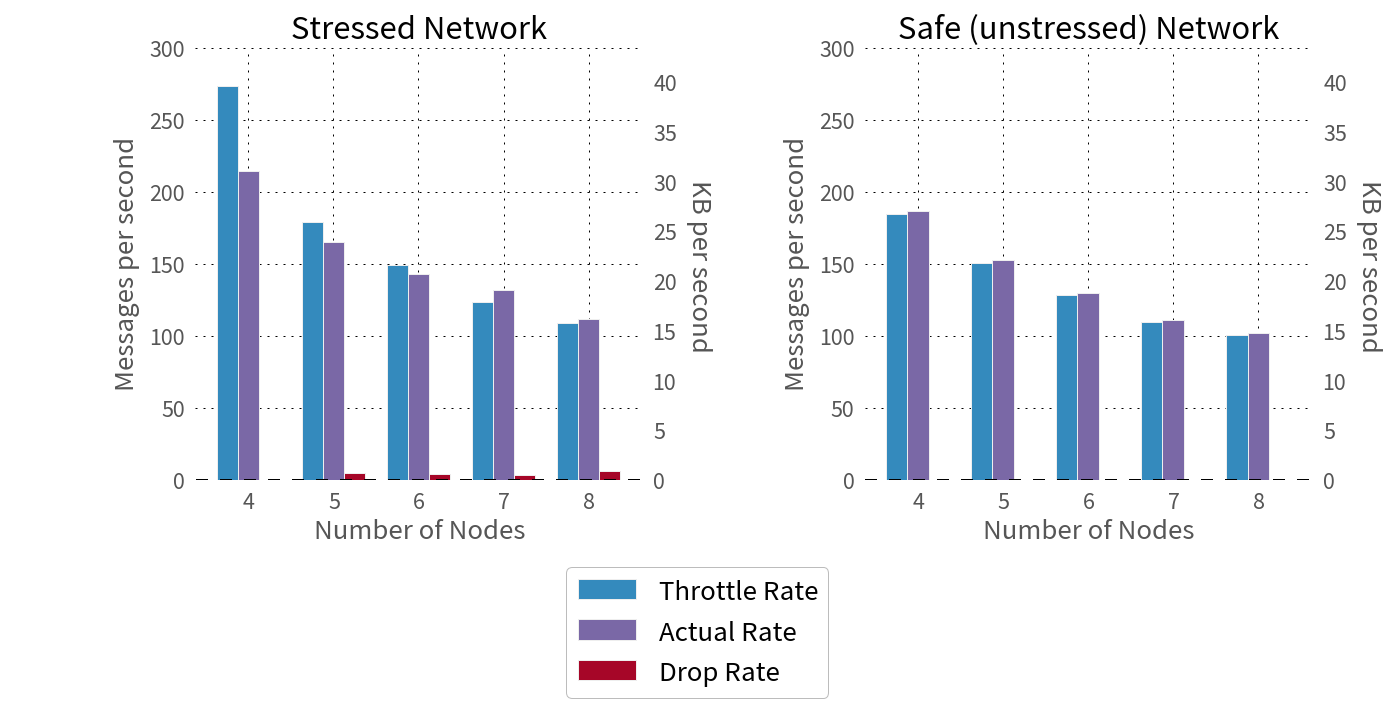

In [14]:
plotIndividualRates()

Some interesting things to note here:

 * For 4 nodes (and fewer), the actual rate will not rise above about 215 messages per second and no messages will be dropped, regardless of how much we increase the sensor throttle rate. This implies that the sensors themselves are not capable of sending more than 215 msgs/s.
 * The actual rate tends to closely match the throttle rate when the network is not stressed.
 * For some reason we sometimes report higher actual rates than throttle rates. It is not immediately clear why, but may have to do with factors such as: The clocks on the sensors might run at a slightly different speed than the server; also the data may be being buffered somewhere and received in bursts

## Cumulative Rates

The graphs above show the average speeds achieved by each sensor individually. If we sum up these values instead of averaging them, we can get a picture of the total data being sent from the sensors to the Venue Server:

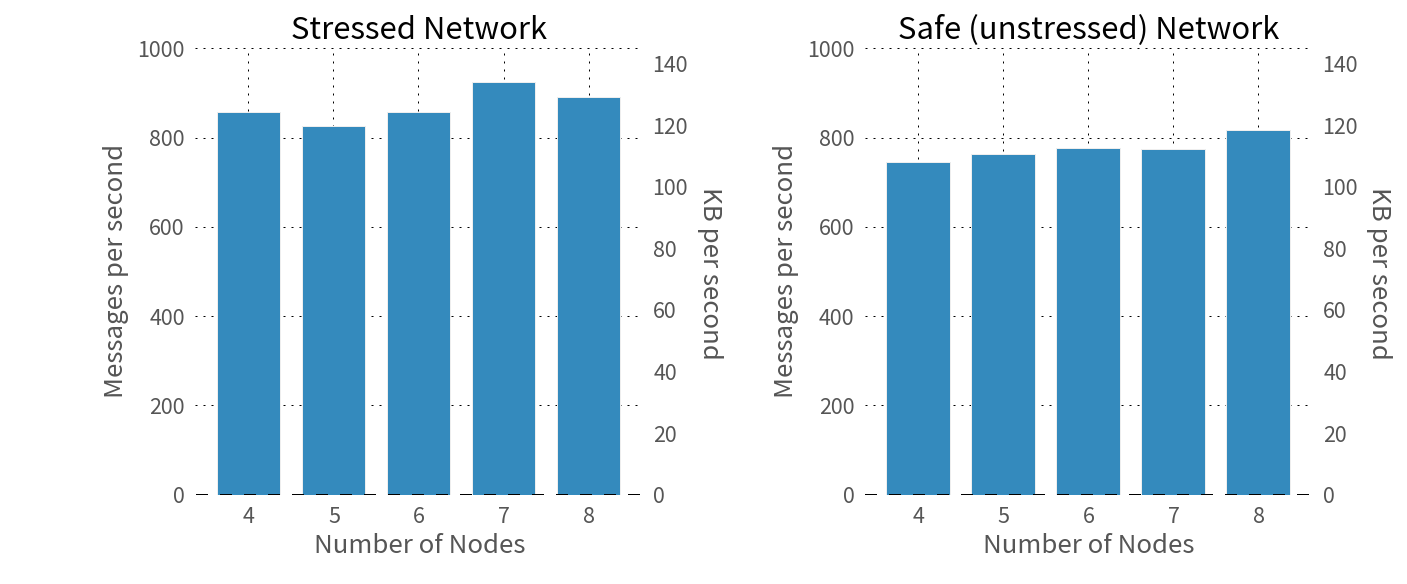

In [7]:
plotCumulativeRates()

These graphs show that the amount of data throughput stays roughly constant as the number of nodes changes. It's not exactly constant, but it is "close".

This approximation is convenient because it implies that the maximum individual node data rate is simply the cumulative rate divided by the number of nodes:

> $$  R_\text{one node}=\frac{R_\text{cumulative}}{N}   $$

For the unstressed network above, the average cumulative speed is 775 messages per second (112 KB/s). Using this value for $ R_\text{cumulative} $ we can project what the message rate and bandwidth would look like for higher numbers of nodes on the network:

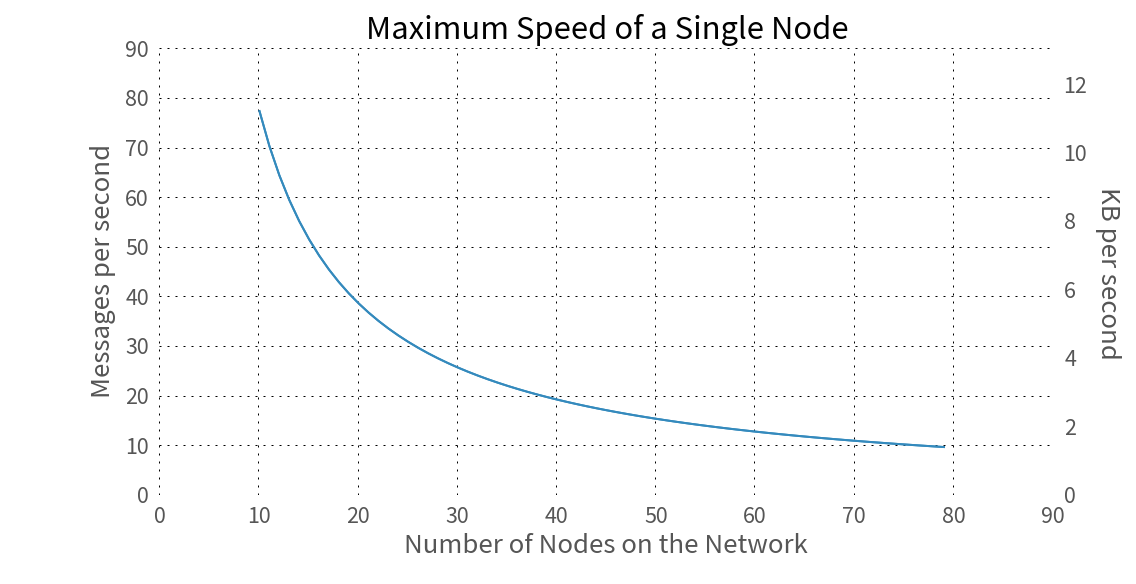

In [8]:
plotPredictedSpeed()

Note that this does _not_ take into account other traffic on the network, which will be expected. Further tests are necessary to determine the impact of other clients using the network, such as the Venue Server web page or live remote control of stage effects.

This prediction also makes a few assumptions and approximations:

 * _The total bandwidth available is constant regardless of the number of nodes._ This comes from a visual inspection of the cumulative graphs above, which only provide us with a few data points. In the 'safe' graph we see that there is actually a slight upward (non-constant) trend. However, if total bandwidth increases slightly with number of nodes, this estimate still provides a lower-bound prediction.
 * _New nodes can be added indefinitely._ This network is based on a wired ethernet network, and this can only support a certain number of clients. It's hard to predict exactly what might happen for 70 nodes as we connect everything together in a tree of switches, and other factors might well come in to play which lower the total available bandwidth.
 * _Other factors (such as performance on the Venue Server) do not create a bottleneck._ We've already seen that both CPU and disk performance on the Raspberry Pi has been a bottleneck, and the numbers above ignore these issues. This prediction assumes we can solve performance issues with the Venue Server.

So while the predictions above are useful, they should be taken with a grain of salt.

## Some Context

To help understand what these numbers mean, it might be helpful to compare to other relevant speeds and rates.

### Video and Animation Frame Rates

Humans perceive a sequence of images as a continuous moving image when the [frame rate](http://en.wikipedia.org/wiki/Frame_rate) is high enough, and we are very sensitive to low frame rates that cause the animation to look "choppy". Typically, at least 24 FPS (frames per second) are required to produce a smooth-looking animation. Modern movies are starting to be filmed at 48 FPS, and most LCD monitors have a refresh rate of about 60 FPS (or Hz, more precisely).

In order to support "high-resolution" display of sensor data, we should be aiming to have about 30 messages per second per sensor node. It is possible to get away with less by interpolating the data, but this smooths out higher-frequency components of the signal. (It's very similar to [scaling up an image](http://en.wikipedia.org/wiki/Image_scaling) in that details are not available.)

### Theoretical Maximum Ethernet Speed

It's very uncommon for real-world speeds to reach manufacturers' specified maximums, but it's worth looking at these values for context.

The ethernet controller we are using (the [ENC28J60](http://ww1.microchip.com/downloads/en/devicedoc/39662a.pdf)) supports a maximum continuous data rate of 10 Mbps (1280 KB/s). We saw a single node achieve a maximum of 31 KB/s. So in theory at least, the nodes are capable of much higher individual performance than we're currently seeing. On the Raspberry Pi, [it looks like it's possible to achieve](http://dhauweele.blogspot.com/2013/03/raspberry-pi-ethernet-speed.html) up to 94 Mbps (11.75 MB/s) on the ethernet controller, so this should not be a bottleneck.

### Comparison to Serial Port Speeds

Prior to implementing the Ethernet setup, we logged data via a serial port which had a cumulative bandwidth of about 7 KB/s. We managed to send 4 signals over it, at 1.8 KB/s each.

Compare this to our new cumulative bandwidth of 112 KB/s. We can now reasonably expect to get 7 KB/s each for 20 nodes, and 3 KB/s each for 40 nodes.

## Initial Conclusions

The current performance is much lower than what is theoretically possible. However even in its current state, these initial numbers imply that it performs faster than our previous system and allows us to trivially connect many sensors, which was not possible before.

We need to finish the test plan to see how things behave once all the moving parts are in place, including logging to disk and additional load on the network. Once these results are in, we will need to look at the various use cases for the system in order to determine whether the current performance is "good enough".
